### Maximum Likelihood tree inference

For this step we are using Reprophylo (Szitenberg et al. 2015), the manual can be found [here](https://docs.google.com/document/d/1Q-8B0cvkZw2zMkuP0Af4zZ7FiAvBQPDdGbrLLMgtx_4/edit#).

Sanger sequences generated for this study:

 - `sequences/c.flor-c.pse_SANGER.fasta` and `sequences/c.flor-c.pse_SANGER_2.fasta`
 
 were collated into a single file:
 - `sequences/c.flor_c.pse_SANGER_full.fasta`
 
 The haplotypes from the metabarcoding data are cointained in:
 - `../3-extract_haplotypes/Crangonyx_haplotypes/Crangonyx_from_metaBEAT.fasta`
 
Other Cragnonyx COI sequences are at:
 - `../1-download_reference/Crangonyx_NCBI_2018.gb`
 - `../1-download_reference/C.islandicus_NCBI_2018.gb`

Import reprophylo functions.

In [1]:
from reprophylo import *

Specifying the locus/loci to be used in the analyses.

The Genbank input files may contain sequences for a range of genes (say you have downloaded full mitochondrial genomes), but you are only interested in a particular gene (say COI). 

So, first we'll want to get an overview of all the genes present in your input Genbank file. Reprophylo has a function for that.

The function will write tentative locus descriptions to the file `loci.csv`, which you may modify, e.g. exclude certain genes from the loci file, or synonymize gene names if necessary.

In [2]:
!cat ../1-NCBI_references/Crangonyx_NCBI_2018.gb ../1-NCBI_references/C.islandicus_NCBI_2018.gb > ../NCBI_records.gb

In [3]:
list_loci_in_genbank('../NCBI_records.gb', 'loci.csv')


There are 2 gene names (or gene product names) detected
----------------------------------
Gene and count sorted by gene name
----------------------------------
12 instances of CDS,coi
54 instances of CDS,COI
-------------------------------
Gene and count sorted by counts
-------------------------------
54 instances of CDS,COI
12 instances of CDS,coi


The function summarizes all gene names detected in the Genbank file. Reprophylo internally already contains a list of synoyms for common genes and attempts to summarize all unique gene names in the file `loci.csv`. 

In [4]:
!cat loci.csv

dna,CDS,MT-CO1,coi,COI


Based on the file `loci.csv` produced by the function we prepare a file `target_loci.csv` that contains all synonyms for the COI gene that appear in the Genbank file. 

In [5]:
%%file target_loci.csv
dna,CDS,MT-CO1,coi,COI,1

Overwriting target_loci.csv


Start a new Reprophylo project, specifying/characterizing the loci to be processed via the `loci.csv` file that we have prepared.

In [6]:
pj = Project('target_loci.csv', pickle='pickle_file/crangonyx_project.pickle', git=False)

DEBUG:Cloud:Log file (/root/.picloud/cloud.log) opened


Check if the Reprophylo project was created correctly.

In [7]:
print pj

Project object with the loci MT-CO1,


Reading in the sequences from Genbank format.

In [8]:
input_files=['../NCBI_records.gb']
pj.read_embl_genbank(input_files)

/home/reprophylo/reprophylo.py:1015: UserWarning: Version control off
  warnings.warn('Version control off')


All sequences are now stored in memory as 'sequence records'. 

How many sequences does our dataset contain?

In [9]:
print len(pj.records)

66


Reading in the new sequences produced from Sanger sequencing or metabarcoding. They will be added to the sequence records with the id 'denovo'

In [10]:
denovo_sequence_filenames=['./sequences/c.flor_c.pse_SANGER.nr.fasta', 
 '../3-extract_haplotypes/Crangonyx_haplotypes/Crangonyx_from_metaBEAT.fasta']

pj.read_denovo(denovo_sequence_filenames, 'dna', format='fasta')

127

In [11]:
print len(pj.records)

193


We are assuming that the sequences that came from Genbank are already in the correct orientation, but we should check that our custom sequences need to be inverted. 

We'll use the `blast` program and a few functions to do that.

`blastn` is installed in the image. Otherwise on ubuntu install like so:

In [12]:
!apt-get install ncbi-blast+

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ncbi-blast+ is already the newest version.
0 upgraded, 0 newly installed, 0 to remove and 317 not upgraded.


In [13]:
!mkdir temp

Write all sequences to file `temp.fasta`.

In [14]:
from Bio import SeqIO

output_handle = open("temp/crangonyx_test.fasta", "w")
SeqIO.write(pj.records, output_handle, "fasta")
output_handle.close()

Convert `temp.fasta` to blast database.

In [15]:
!makeblastdb -in temp/crangonyx_test.fasta -dbtype nucl -out temp/all



Building a new DB, current time: 07/24/2019 21:33:11
New DB name:   temp/all
New DB title:  temp/crangonyx_test.fasta
Sequence type: Nucleotide
Keep Linkouts: T
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 193 sequences in 0.00636697 seconds.


Perform blast search.

In [16]:
!blastn -db temp/all -query temp/crangonyx_test.fasta -outfmt '6 qseqid sseqid qstart qend sstart send' -out temp/crangonyx_test.blastn.out

Identify any denovo sequences that match with non-denovo sequences in reverse complement.

In [17]:
blastout=open('temp/crangonyx_test.blastn.out')

to_invert=[]
for line in blastout:
    col=line.strip().split("\t")
    if 'denovo' in col[0]:
#        print col
        if (int(col[-2]) > int(col[-1])) and (not 'denovo' in col[1]):
#            print "## invert ##"
            to_invert.append(col[0])
        
to_invert=list(set(to_invert))
print "Records to invert:\n%s" %to_invert

blastout.close()

Records to invert:
[]


Reverse complement records.

In [18]:
if to_invert:
    print "There are records to invert\n"
    for r in pj.records:
        if r.id in to_invert:
            print "\t-> %s" %r.id
            r.seq = r.seq.reverse_complement()
            to_invert.remove(r.id)
else:
    print "Nothing to invert\n"

Nothing to invert



Remove temporal directory.

In [19]:
!rm -rf temp

Now, lets print a summary of the number of sequences per species.

In [20]:
pj.species_vs_loci('species.csv')

In [21]:
!cat species.csv

Some sequences seem to be missing. This is because the `species_by_loci` function only considers sequence records that are identified with the correct gene identifier. We need to add this for our custom sequences so that reprophylo understands that these sequences are to be analysed together with the COI sequences that we have loaded from the Genbank data.

In [22]:
for r in pj.records:
    if 'denovo' in r.id:
        pj.add_feature_to_record(r.id, 'CDS', qualifiers={'gene': 'MT-CO1'})

In [23]:
pj.species_vs_loci('species.csv')

In [24]:
!cat species.csv

Better, but our custom sequences are now assigned to an undefied species. We'll need to add the species to the record. We will look in the original header of the sequence for the species name and add the appropriate organism name to the sequence record.

In [25]:
for r in pj.records:
    source=r.features[0]
    if 'denovo' in r.id:
        if 'floridanus' in source.qualifiers['original_id'][0]:
           r.features[0].qualifiers['organism'] = ['Crangonyx floridanus']
        elif 'pseudogracilis' in source.qualifiers['original_id'][0]:
            r.features[0].qualifiers['organism'] = ['Crangonyx pseudogracilis']


In [26]:
pj.species_vs_loci('species.csv')

In [27]:
!cat species.csv

Now, we produce some stats for the sequences in our dataset.

In [28]:
pj.extract_by_locus()

Distribution Of Sequence Lengths
Distribution Of Sequence Statistic "Gc_Content"


/usr/lib/pymodules/python2.7/matplotlib/figure.py:371: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


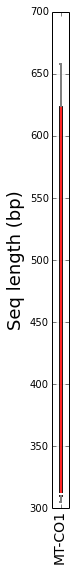

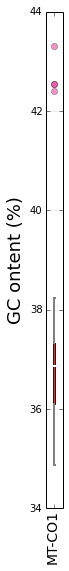

In [29]:
%matplotlib inline
pj.report_seq_stats()


The sequences in the dataset are of different lengths. Sequences downloaded from Genbank (generated by Slothouber Galbreath et al. 2010; Nagabuko et al. 2011) have quite a broad range up to the full 658bp-long COI barcoding region (Folmer et al. 1994). The Sanger sequences produced for this study were also based on the full length COI barcode. Sequences obtained via eDNA metabarcoding instead are the shorter Leray fragment (313bp) (Leray et al. 2013).

We will generate three separate alignments.
 - 'ALL': All sequences from Genbank and current study (Sanger Folmer- and metabarcoding mini-barcode fragment)
 - 'FOLMER': Sequences from Genbank and current study Sanger Folmer fragments only
 - 'MINIBC': Sequences from Genbank and current study metabarcoding mini-barcode fragments only

Configure and run sequence alignment 'ALL' with mafft.

In [30]:
mafft_linsi = AlnConf(pj, 
                      method_name='ALL', 
                      CDSAlign=False, 
                      program_name='mafft', 
                      cmd='mafft', 
                      loci=['MT-CO1'], 
                      cline_args={'localpair': True, 'maxiterate': 1000})

mafft --localpair --maxiterate 1000 578471564003996.92_MT-CO1.fasta


Execute sequence alignment process.

In [31]:
pj.align([mafft_linsi])

Display information about the alignment method.

In [32]:
print pj.used_methods['ALL']

AlnConf named ALL with ID 578471564003996.92
Loci: MT-CO1 
Created on: Wed Jul 24 21:33:16 2019
Commands:
MT-CO1: mafft --localpair --maxiterate 1000 578471564003996.92_MT-CO1.fasta

Environment:
Platform: Linux-4.4.0-151-generic-x86_64-with-Ubuntu-14.04-trusty
 Processor: x86_64
 Python build: defaultMar 22 2014 22:59:56
 Python compiler: GCC 4.8.2
 Python implementation: CPython
 Python version: 2.7.6
 ete2 version: 2.2.1072
 biopython version: 1.70
 dendropy version: 4.3.0
 cloud version: 2.8.5
 reprophylo version 1.3
 User: biopc7
 Program and version: MAFFT v7.123b
 Program reference:Katoh
 Standley 2013 (Molecular Biology and Evolution 30:772-780) MAFFT multiple sequence alignment software version 7: improvements in performance and usability.
execution time:
34.8819701672


Core Methods section sentence:
The dataset(s) MT-CO1 were aligned using the program MAFFT v7.123b [1].

Reference:
Katoh, Standley 2013 (Molecular Biology and Evolution 30:772-780) MAFFT multiple sequence alig

Produce the alignemnt 'FOLMER', i.e. remove all minibarcode sequences. These have the ids >= `denovo6`.

In [33]:
for r in pj.records:
    if 'denovo' in r.id:
        print r.id,r.description

denovo0 CHASE103_C_floridanus_SANGER
denovo1 CHASE412_C_pseudogracilis_SANGER
denovo2 F53MOI2C_C_floridanus_SANGER
denovo3 THWA03_C_pseudogracilis_SANGER
denovo4 THWA01_C_pseudogracilis_SANGER
denovo5 FCHASE203_C_floridanus_SANGER
denovo6 Crangonyx_floridanus|Cf_UK_Mb-01
denovo7 Crangonyx_floridanus|Cf_UK_Mb-02
denovo8 Crangonyx_floridanus|Cf_UK_Mb-03
denovo9 Crangonyx_floridanus|Cf_UK_Mb-04
denovo10 Crangonyx_floridanus|Cf_UK_Mb-05
denovo11 Crangonyx_floridanus|Cf_UK_Mb-06
denovo12 Crangonyx_floridanus|Cf_UK_Mb-07
denovo13 Crangonyx_floridanus|Cf_UK_Mb-08
denovo14 Crangonyx_floridanus|Cf_UK_Mb-09
denovo15 Crangonyx_floridanus|Cf_UK_Mb-10
denovo16 Crangonyx_floridanus|Cf_UK_Mb-11
denovo17 Crangonyx_floridanus|Cf_UK_Mb-12
denovo18 Crangonyx_floridanus|Cf_UK_Mb-13
denovo19 Crangonyx_floridanus|Cf_UK_Mb-14
denovo20 Crangonyx_floridanus|Cf_UK_Mb-15
denovo21 Crangonyx_floridanus|Cf_UK_Mb-16
denovo22 Crangonyx_floridanus|Cf_UK_Mb-17
denovo23 Crangonyx_floridanus|Cf_UK_Mb-18
denovo24 Crangony

In [34]:
#Empty sequence object
seqobject = []

#Add all records except the record ids >= 'denovo6' to new object
for r in pj.records_by_locus['MT-CO1']:
    if 'denovo' in r.id:
        denovoID=int(r.id.replace('denovo','').replace('_f0',''))
#        print denovoID
        if denovoID >= 6:
            pass
        else:
            seqobject.append(r)
    else:
        seqobject.append(r)

#Replace original object with new 
pj.records_by_locus['MT-CO1'] = seqobject

Configure and run alignment.

In [35]:
mafft_linsi = AlnConf(pj, 
                      method_name='FOLMER', 
                      CDSAlign=False, 
                      program_name='mafft', 
                      cmd='mafft', 
                      loci=['MT-CO1'], 
                      cline_args={'localpair': True, 'maxiterate': 1000})

mafft --localpair --maxiterate 1000 927521564004032.08_MT-CO1.fasta


In [36]:
pj.align([mafft_linsi])

Restore original alignemnt object.

In [37]:
pj.extract_by_locus()

Produce the alignemnt 'MINIBC', i.e. remove all minibarcode sequences. These have ids <= `denovo5`.

In [38]:
#Empty sequence object
seqobject = []

#Add all records except the record ids >= 'denovo6' to new object
for r in pj.records_by_locus['MT-CO1']:
    if 'denovo' in r.id:
        denovoID=int(r.id.replace('denovo','').replace('_f0',''))
#        print denovoID
        if denovoID <= 5:
            pass
        else:
            seqobject.append(r)
    else:
        seqobject.append(r)

#Replace original object with new 
pj.records_by_locus['MT-CO1'] = seqobject

Configure and run alignment.

In [39]:
mafft_linsi = AlnConf(pj, 
                      method_name='MINIBC', 
                      CDSAlign=False, 
                      program_name='mafft', 
                      cmd='mafft', 
                      loci=['MT-CO1'], 
                      cline_args={'localpair': True, 'maxiterate': 1000})

mafft --localpair --maxiterate 1000 924181564004040.97_MT-CO1.fasta


In [40]:
pj.align([mafft_linsi])

Restore original alignment object.

In [41]:
pj.extract_by_locus()

Write alignments to files for checking in e.g. `Aliview`.

In [42]:
pj.write_alns(id=['record_id', 'source_organism'], format='fasta')

['MT-CO1@MINIBC_aln.fasta', 'MT-CO1@FOLMER_aln.fasta', 'MT-CO1@ALL_aln.fasta']

Trim each of the three alignemnts to remove any positions that are not covered by at least 70, 80, and 90% of the records.

In [43]:
gt70trimal = TrimalConf(pj, 
                        method_name='gt70', 
                        program_name='trimal', 
                        cmd='trimal', 
                        alns=['MT-CO1@ALL', 'MT-CO1@FOLMER', 'MT-CO1@MINIBC'], 
                        trimal_commands={'gt': 0.7})

trimal -in 262541564004072.82_MT-CO1@MINIBC.fasta -gt 0.7
trimal -in 262541564004072.82_MT-CO1@FOLMER.fasta -gt 0.7
trimal -in 262541564004072.82_MT-CO1@ALL.fasta -gt 0.7


In [44]:
gt80trimal = TrimalConf(pj, 
                        method_name='gt80', 
                        program_name='trimal', 
                        cmd='trimal', 
                        alns=['MT-CO1@ALL', 'MT-CO1@FOLMER', 'MT-CO1@MINIBC'], 
                        trimal_commands={'gt': 0.8})

trimal -in 675031564004072.83_MT-CO1@MINIBC.fasta -gt 0.8
trimal -in 675031564004072.83_MT-CO1@FOLMER.fasta -gt 0.8
trimal -in 675031564004072.83_MT-CO1@ALL.fasta -gt 0.8


In [45]:
gt90trimal = TrimalConf(pj, 
                        method_name='gt90', 
                        program_name='trimal', 
                        cmd='trimal', 
                        alns=['MT-CO1@ALL', 'MT-CO1@FOLMER', 'MT-CO1@MINIBC'], 
                        trimal_commands={'gt': 0.9})

trimal -in 843991564004072.84_MT-CO1@MINIBC.fasta -gt 0.9
trimal -in 843991564004072.84_MT-CO1@FOLMER.fasta -gt 0.9
trimal -in 843991564004072.84_MT-CO1@ALL.fasta -gt 0.9


In [46]:
pj.trim([gt70trimal,gt80trimal,gt90trimal])

In [47]:
print pj.used_methods['gt90']

TrimalConf named gt90 with ID 843991564004072.84
Alignments: MT-CO1@MINIBC,MT-CO1@FOLMER,MT-CO1@ALL 
Created on: Wed Jul 24 21:34:32 2019
Commands:
MT-CO1@FOLMER@gt90: trimal -in 843991564004072.84_MT-CO1@FOLMER.fasta -gt 0.9
MT-CO1@ALL@gt90: trimal -in 843991564004072.84_MT-CO1@ALL.fasta -gt 0.9
MT-CO1@MINIBC@gt90: trimal -in 843991564004072.84_MT-CO1@MINIBC.fasta -gt 0.9

Environment:Platform: Linux-4.4.0-151-generic-x86_64-with-Ubuntu-14.04-trusty
 Processor: x86_64
 Python build: defaultMar 22 2014 22:59:56
 Python compiler: GCC 4.8.2
 Python implementation: CPython
 Python version: 2.7.6
 ete2 version: 2.2.1072
 biopython version: 1.70
 dendropy version: 4.3.0
 cloud version: 2.8.5
 reprophylo version 1.3
 User: biopc7
 Program and version: trimAl 1.2rev59
 Program reference: Salvador Capella-Gutierrez; Jose M. Silla-Martinez; Toni Gabaldon. trimAl: a tool for automated alignment trimming in large-scale phylogenetic analyses. Bioinformatics 2009 25: 1972-1973.
execution time:
1.44

In [48]:
pj.write_trimmed_alns(id=['record_id', 'source_organism'], format='fasta')

['MT-CO1@MINIBC@gt80_trimmed_aln.fasta',
 'MT-CO1@ALL@gt70_trimmed_aln.fasta',
 'MT-CO1@MINIBC@gt90_trimmed_aln.fasta',
 'MT-CO1@MINIBC@gt70_trimmed_aln.fasta',
 'MT-CO1@ALL@gt80_trimmed_aln.fasta',
 'MT-CO1@FOLMER@gt70_trimmed_aln.fasta',
 'MT-CO1@ALL@gt90_trimmed_aln.fasta',
 'MT-CO1@FOLMER@gt90_trimmed_aln.fasta',
 'MT-CO1@FOLMER@gt80_trimmed_aln.fasta']

Configure tree building.

In [49]:
raxml = RaxmlConf(pj, method_name='mafftLinsi-trimal', 
                 program_name='raxmlHPC-PTHREADS-SSE3',
                 keepfiles=True,
                 cmd='raxmlHPC-PTHREADS-SSE3',
                 preset='fa',
                 alns=['MT-CO1@FOLMER@gt80','MT-CO1@ALL@gt80','MT-CO1@MINIBC@gt80',
                      'MT-CO1@FOLMER@gt70','MT-CO1@ALL@gt70','MT-CO1@MINIBC@gt70',
                      'MT-CO1@FOLMER@gt90','MT-CO1@ALL@gt90','MT-CO1@MINIBC@gt90'],
                 model='GAMMA',
                 threads=3,
                 cline_args={'-#': 100})

raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 264361564004077.89_MT-CO1@MINIBC@gt800 -p 483 -s 264361564004077.89_MT-CO1@MINIBC@gt80.fasta -T 3 -x 294 -N 100
raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 264361564004077.89_MT-CO1@ALL@gt700 -p 712 -s 264361564004077.89_MT-CO1@ALL@gt70.fasta -T 3 -x 140 -N 100
raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 264361564004077.89_MT-CO1@MINIBC@gt900 -p 322 -s 264361564004077.89_MT-CO1@MINIBC@gt90.fasta -T 3 -x 329 -N 100
raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 264361564004077.89_MT-CO1@MINIBC@gt700 -p 490 -s 264361564004077.89_MT-CO1@MINIBC@gt70.fasta -T 3 -x 599 -N 100
raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 264361564004077.89_MT-CO1@ALL@gt800 -p 703 -s 264361564004077.89_MT-CO1@ALL@gt80.fasta -T 3 -x 396 -N 100
raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 264361564004077.89_MT-CO1@FOLMER@gt700 -p 451 -s 264361564004077.89_MT-CO1@FOLMER@gt70.fasta -T 3 -x 646 -N 100
raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 264361564004077.89_MT-CO1@ALL@gt900 -p 

In [50]:
pj.tree([raxml])

In [51]:
print pj.used_methods['mafftLinsi-trimal']

RaxmlConf named mafftLinsi-trimal with ID 264361564004077.89
Alignments: MT-CO1@MINIBC@gt80,MT-CO1@ALL@gt70,MT-CO1@MINIBC@gt90,MT-CO1@MINIBC@gt70,MT-CO1@ALL@gt80,MT-CO1@FOLMER@gt70,MT-CO1@ALL@gt90,MT-CO1@FOLMER@gt90,MT-CO1@FOLMER@gt80 
Created on: Wed Jul 24 21:34:37 2019
Commands:
MT-CO1@MINIBC@gt80:
raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 264361564004077.89_MT-CO1@MINIBC@gt800 -p 483 -s 264361564004077.89_MT-CO1@MINIBC@gt80.fasta -T 3 -x 294 -N 100
MT-CO1@ALL@gt70:
raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 264361564004077.89_MT-CO1@ALL@gt700 -p 712 -s 264361564004077.89_MT-CO1@ALL@gt70.fasta -T 3 -x 140 -N 100
MT-CO1@MINIBC@gt90:
raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 264361564004077.89_MT-CO1@MINIBC@gt900 -p 322 -s 264361564004077.89_MT-CO1@MINIBC@gt90.fasta -T 3 -x 329 -N 100
MT-CO1@MINIBC@gt70:
raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 264361564004077.89_MT-CO1@MINIBC@gt700 -p 490 -s 264361564004077.89_MT-CO1@MINIBC@gt70.fasta -T 3 -x 599 -N 100
MT-CO1@ALL@gt80:
raxmlHPC-

Pickle the project.

In [52]:
pickle_pj(pj, 'pickle_file/crangonyx_project.pickle')

'pickle_file/crangonyx_project.pickle'

## Annotate ML trees.

Define outgroups.

In [53]:
!cat species.csv

In [54]:
pj.add_qualifier_from_source('organism')


In [55]:
for species in ['Synurella','Crangonyx_islandicus']:
    pj.if_this_then_that(species, 'organism', 'outgroup', 'outgroup',
                         mode='part')

Specify colors for branchsupport.

In [56]:
supports = {'black': [100,95],
            'dimgray': [95,75],
            'silver': [75,50]}

Add a new qualifier 'origin' that contains either 'Sanger' or 'metabarcoding' for the newly generated sequences. Also we add another qualifier 'origin_abr' that contains the symbols * or +, respectively.



In [57]:
for r in pj.records:
    if 'denovo' in r.id:
        print r.id
        ## all the Sanger sequences contain the string 'HCO2198' in the sequence header
        if 'SANGER' in r.description:
            print "origin -> Sanger"
            for f in r.features:
                f.qualifiers['origin'] = ['Sanger']
                f.qualifiers['origin_abr'] = ['s']
        ## if they are don't contain 'HCO2198' they originate from metabarcoding
        else:
            print "origin -> metabarcoding"
            for f in r.features:
                f.qualifiers['origin'] = ['metabarcoding']
                f.qualifiers['origin_abr'] = ['+']
    #if they are not 'denovo' then they were from a previous study
    else:
        print r.id
        print "origin -> previous study"
        for f in r.features:
            f.qualifiers['origin'] = ['']
            f.qualifiers['origin_abr'] = ['']

AB513800.1
origin -> previous study
AB513801.1
origin -> previous study
AB513802.1
origin -> previous study
AB513803.1
origin -> previous study
AB513804.1
origin -> previous study
AB513805.1
origin -> previous study
AB513806.1
origin -> previous study
AB513807.1
origin -> previous study
AB513808.1
origin -> previous study
AB513809.1
origin -> previous study
AB513810.1
origin -> previous study
AB513811.1
origin -> previous study
AB513812.1
origin -> previous study
AB513813.1
origin -> previous study
AB513814.1
origin -> previous study
AB513815.1
origin -> previous study
AB513816.1
origin -> previous study
AB513817.1
origin -> previous study
AB513818.1
origin -> previous study
AB513819.1
origin -> previous study
AB513820.1
origin -> previous study
AB513821.1
origin -> previous study
AB513822.1
origin -> previous study
AB513823.1
origin -> previous study
AB513824.1
origin -> previous study
AB513825.1
origin -> previous study
AB513826.1
origin -> previous study
AB513827.1
origin -> previou

In [58]:
pj.propagate_metadata()

Refine tree annotation.

Format tree to add symbols * or + to leaf name to indicate 'Sanger' or 'metabarcoding' sequences, respectively.

In [59]:
pj.clear_tree_annotations()
pj.annotate('.', 'outgroup', 'outgroup', 
            ['source_organism','record_id','origin_abr'], 
            node_support_dict=supports, multifurc=10,
            html='./mafftLinsi-trimal-raxml.html')

Color the tree labels according to origin of the sequences.

In [60]:
leaf_colors = {'Sanger':'red', 'metabarcoding': 'blue'}

In [61]:
pj.clear_tree_annotations()
pj.annotate('.', 'mid', 'mid', 
            ['source_organism', 'record_id'], 
            node_support_dict=supports, multifurc=50, #None
            leaf_node_color_meta = 'origin', leaf_label_colors = leaf_colors,
            html='./mafftLinsi-trimal-raxml.html')

Add haplotype abbreviations to records to be used as tree tip labels.

In [62]:
MB_count={'Cp':1, 'Cf':1}
FO_count={'Cp':1, 'Cf':1}
for r in pj.records:
    print r.id,r.features[0].qualifiers['organism'][0]

    if r.features[0].qualifiers['organism'][0].split(" ")[1] in ['pseudogracilis','floridanus','islandicus']:
        sp_prefix = r.features[0].qualifiers['organism'][0].split(" ")[0][0]+r.features[0].qualifiers['organism'][0].split(" ")[1][0]
        if 'denovo' in r.id:
            if 'metabarcoding' in r.features[0].qualifiers['origin']:
                for f in r.features:
                    f.qualifiers['label'] = [r.description.split("|")[1]]
                print r.features[0].qualifiers['label']
                MB_count[sp_prefix]+=1
            if 'Sanger' in r.features[0].qualifiers['origin']:
                for f in r.features:
                    f.qualifiers['label'] = [sp_prefix+'_UK-Sanger_'+"%02d" %FO_count[sp_prefix]]
                print r.features[0].qualifiers['label']
                FO_count[sp_prefix]+=1
        elif r.id.startswith('AB') or r.id.startswith('AJ') or r.id.startswith('MK'):
            for f in r.features:
                f.qualifiers['label'] = [sp_prefix+'_'+r.features[0].qualifiers['country'][0][:3]+'_'+r.features[0].qualifiers['isolate'][0]]
            print r.features[0].qualifiers['label']
        elif r.id.startswith('EF'):
            for f in r.features:
                f.qualifiers['label'] = [sp_prefix+'_'+r.features[0].qualifiers['country'][0][:3]+'_'+r.features[0].qualifiers['specimen_voucher'][0]]
#                f.qualifiers['label'] = r.features[0].qualifiers['specimen_voucher']
            print r.features[0].qualifiers['label']
        else:
            for f in r.features:
                f.qualifiers['label'] = [sp_prefix+'_'+r.features[0].qualifiers['isolate'][0]]
            print r.features[0].qualifiers['label']
    else:
        for f in r.features:
            f.qualifiers['label'] = r.features[0].qualifiers['organism']
        print r.features[0].qualifiers['label']

AB513800.1 Crangonyx floridanus
['Cf_Jap_CF-1291']
AB513801.1 Crangonyx floridanus
['Cf_Jap_CF-1292']
AB513802.1 Crangonyx floridanus
['Cf_Jap_CF-1642']
AB513803.1 Crangonyx floridanus
['Cf_Jap_CF-1643']
AB513804.1 Crangonyx floridanus
['Cf_Jap_CF-1644']
AB513805.1 Crangonyx floridanus
['Cf_Jap_CF-1645']
AB513806.1 Crangonyx floridanus
['Cf_Jap_CF-1647']
AB513807.1 Crangonyx floridanus
['Cf_Jap_CF-1650']
AB513808.1 Crangonyx floridanus
['Cf_Jap_CF-1690']
AB513809.1 Crangonyx floridanus
['Cf_Jap_CF-1691']
AB513810.1 Crangonyx floridanus
['Cf_Jap_CF-1692']
AB513811.1 Crangonyx floridanus
['Cf_Jap_CF-1693']
AB513812.1 Crangonyx floridanus
['Cf_Jap_CF-1694']
AB513813.1 Crangonyx floridanus
['Cf_Jap_CF-1695']
AB513814.1 Crangonyx floridanus
['Cf_Jap_CF-1696']
AB513815.1 Crangonyx floridanus
['Cf_Jap_CF-1697']
AB513816.1 Crangonyx floridanus
['Cf_Jap_CF-1740']
AB513817.1 Crangonyx floridanus
['Cf_Jap_CF-1741']
AB513818.1 Crangonyx floridanus
['Cf_Jap_CF-1742']
AB513819.1 Crangonyx floridanus

In [63]:
pj.propagate_metadata()

In [64]:
pj.clear_tree_annotations()
pj.annotate('.', 'outgroup', 'outgroup', 
            ['label'], 
            node_support_dict=supports, multifurc=None,
            leaf_node_color_meta = 'origin', leaf_label_colors = leaf_colors,
            scale = 1000,
           html='./mafftLinsi-trimal-raxml.html')

Write out alignments again, adding the new label names.

In [65]:
pj.write_alns(id=['record_id', 'label'], format='fasta')

['MT-CO1@MINIBC_aln.fasta', 'MT-CO1@FOLMER_aln.fasta', 'MT-CO1@ALL_aln.fasta']

In [66]:
pj.write_trimmed_alns(id=['record_id', 'label'], format='fasta')

['MT-CO1@MINIBC@gt80_trimmed_aln.fasta',
 'MT-CO1@ALL@gt70_trimmed_aln.fasta',
 'MT-CO1@MINIBC@gt90_trimmed_aln.fasta',
 'MT-CO1@MINIBC@gt70_trimmed_aln.fasta',
 'MT-CO1@ALL@gt80_trimmed_aln.fasta',
 'MT-CO1@FOLMER@gt70_trimmed_aln.fasta',
 'MT-CO1@ALL@gt90_trimmed_aln.fasta',
 'MT-CO1@FOLMER@gt90_trimmed_aln.fasta',
 'MT-CO1@FOLMER@gt80_trimmed_aln.fasta']

Copy phylogenetic trees and underlying alignments in separate directory as supplement for the paper.

In [67]:
mkdir supplementary

mkdir: cannot create directory ‘supplementary’: File exists


In [68]:
%%bash

#copy and rename phylogenies
for p in $(ls -1 *.png)
do
    base=$(echo $p | cut -d "_" -f 2-)
    cp $p supplementary/RAxML_GTRGAMMA-$base
done

#copy alignments
cp MT-CO1* supplementary/

In [69]:
!mkdir supplementary/RAxML/

mkdir: cannot create directory ‘supplementary/RAxML/’: File exists


In [70]:
!mv RAxML_* supplementary/RAxML/

Pickle Reprophylo project for later.

In [71]:
pickle_pj(pj, 'pickle_file/crangonyx_project.pickle')

'pickle_file/crangonyx_project.pickle'

In [72]:
!cp pickle_file/crangonyx_project.pickle supplementary/

Generate supplementary table linking haplotypes with accession numbers.

In [145]:
references = {}

#previously published sequences used in the phylogeny
refs = open('../1-NCBI_references/phylogeny_refseqs.csv','r')
refs.next()
for r in refs:
    cols=r.strip().split(",")
    references[cols[1]] = cols[2]

hts = {}   

#read in Genbank accessions for sequences produced in this study from text file
acc_fh = open('supplementary/this_study_ht_to_accessions.tsv')
ht_to_new_accs = {}
for ht in acc_fh:
    ht_to_new_accs[ht.strip().split("\t")[0]] = ht.strip().split("\t")[1]

#
for r in pj.records:
    hts[r.features[0].qualifiers['label'][0]] = "%s" %r.features[0].qualifiers['organism'][0]
    
    if ".".join(r.id.split(".")[:-1]) in references:
        hts[r.features[0].qualifiers['label'][0]]+= "\t%s\t%s" %(r.id, references[".".join(r.id.split(".")[:-1])])

    else:
        hts[r.features[0].qualifiers['label'][0]]+= "\t"+ht_to_new_accs[r.features[0].qualifiers['label'][0]]+"\tcurrent study"


out='sequence id\tspecies\tGenbank accession\treference\n'
for s in sorted(hts.keys()):
    out+="%s\t%s\n" %(s, hts[s])

print out

outfh=open('supplementary/ht_accessions.tsv','w')
outfh.write(out)
outfh.close()

IOError: [Errno 2] No such file or directory: '../1-NCBI_references/phylogeny_refseqs.csv'